In [ ]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision.datasets import CIFAR10
from torchvision.datasets import FashionMNIST

RANDOM_SEED = 1
torch.manual_seed(RANDOM_SEED)

# Prepare dataset

In [ ]:
N_CLASSES= 10
EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 1e-4

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

val_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# Architecture of AlexNet

In [ ]:
class AlexNet(nn.Module):
  def __init__(self, n_classes):
    super(AlexNet, self).__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=1),
        nn.ReLU(), 
        nn.MaxPool2d(kernel_size=3, stride=2)
    )
    print(self.conv_block1)
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2)
    )
    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    )
    self.conv_block4 = nn.Sequential(
        nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    )
    self.conv_block5 = nn.Sequential(
        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(), 
        nn.MaxPool2d(kernel_size=3, stride=2)
    )
    self.flatten = nn.Flatten()
    self.fc_layer1 = nn.Sequential(
        nn.Linear(256 * 5 * 5, 4096),
        nn.ReLU(),
        nn.Dropout(0.5)
    )
    self.fc_layer2 = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(0.5)
    )
    self.fc_layer3 = nn.Linear(4096, n_classes)

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.conv_block3(x)
    x = self.conv_block4(x)
    x = self.conv_block5(x)
    x = self.flatten(x)
    x = self.fc_layer1(x)
    x = self.fc_layer2(x)
    x = self.fc_layer3(x)
    return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('USING {} FOR TRAINING THE ALEXNET'.format(device))
model = AlexNet(10)
model.to(device)

USING cuda FOR TRAINING THE ALEXNET
Sequential(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


AlexNet(
  (conv_block1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_block4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_block5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layer1): Sequential(
    (0): Linear(in_features=6400, out_

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
              ReLU-2           [-1, 96, 54, 54]               0
         MaxPool2d-3           [-1, 96, 26, 26]               0
            Conv2d-4          [-1, 256, 26, 26]         614,656
              ReLU-5          [-1, 256, 26, 26]               0
         MaxPool2d-6          [-1, 256, 12, 12]               0
            Conv2d-7          [-1, 384, 12, 12]         885,120
              ReLU-8          [-1, 384, 12, 12]               0
            Conv2d-9          [-1, 384, 12, 12]       1,327,488
             ReLU-10          [-1, 384, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         884,992
             ReLU-12          [-1, 256, 12, 12]               0
        MaxPool2d-13            [-1, 256, 5, 5]               0
          Flatten-14                 [-

# TRAINING THE ALEXNET WITH CIFAR10

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

training_steps = len(train_dataloader)
val_steps = len(val_dataloader)

training_losses = []
val_losses = []

val_accs = []

print('Start Training...\n')
for epoch in range(EPOCHS):
    total_training_loss = 0
    model.train()
    for idx, (X_train, y_train) in enumerate(train_dataloader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        total_training_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    training_loss = total_training_loss / training_steps
    training_losses.append(training_loss)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Training Loss: {training_loss:.3f}')

    with torch.no_grad():
        model.eval()
        n_correct_preds = 0
        n_val_samples = 0
        total_val_loss = 0
        for idx, (X_val, y_val) in enumerate(val_dataloader):
            X_val = X_val.to(device)
            y_val = y_val.to(device)

            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            total_val_loss += loss.item()

            y_pred_max, y_pred_max_idx = torch.max(y_pred, 1)
            n_val_samples += y_pred.size(0)
            n_correct_preds += (y_val == y_pred_max_idx).sum().item()

        val_acc = n_correct_preds / n_val_samples
        val_loss = total_val_loss / val_steps
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.3f}\n')

print('Training Completed')

Start Training...

Epoch [1/50], Training Loss: 1.891
Val Loss: 1.598, Val Accuracy: 0.410

Epoch [2/50], Training Loss: 1.445
Val Loss: 1.290, Val Accuracy: 0.528

Epoch [3/50], Training Loss: 1.250
Val Loss: 1.204, Val Accuracy: 0.572

Epoch [4/50], Training Loss: 1.091
Val Loss: 1.019, Val Accuracy: 0.643

Epoch [5/50], Training Loss: 0.972
Val Loss: 0.947, Val Accuracy: 0.665

Epoch [6/50], Training Loss: 0.880
Val Loss: 0.880, Val Accuracy: 0.687

Epoch [7/50], Training Loss: 0.801
Val Loss: 0.806, Val Accuracy: 0.718

Epoch [8/50], Training Loss: 0.723
Val Loss: 0.775, Val Accuracy: 0.732

Epoch [9/50], Training Loss: 0.660
Val Loss: 0.680, Val Accuracy: 0.763

Epoch [10/50], Training Loss: 0.611
Val Loss: 0.683, Val Accuracy: 0.761

Epoch [11/50], Training Loss: 0.556
Val Loss: 0.701, Val Accuracy: 0.758

Epoch [12/50], Training Loss: 0.500
Val Loss: 0.627, Val Accuracy: 0.781

Epoch [13/50], Training Loss: 0.450
Val Loss: 0.655, Val Accuracy: 0.778

Epoch [14/50], Training Loss

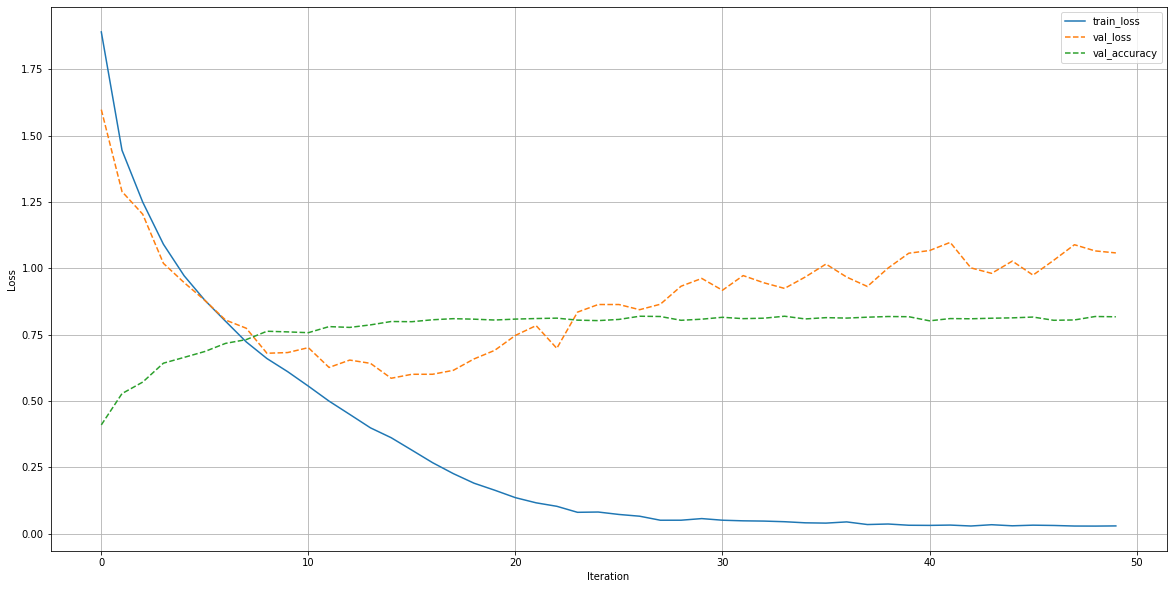

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(training_losses, label = "train_loss")
plt.plot(val_losses, linestyle='--', label = "val_loss")
plt.plot(val_accs, linestyle='--', label = 'val_accuracy')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid()